# De-embedding

This is a short tutorial on how de-embedding can be performed using scikit-rf. We will start by introducing the concept of de-embedding and why it is required, with a simple use-case scenario. Next, we will go through what kinds of de-embedding exist, and how to choose the right one for your application. Lastly, we will see how code can be written to quickly perform de-embedding on your s-parameter datasets.

## What is de-embedding and how does it differ from calibration?

Let's start with an example. Consider the measurement of integrated RF transistors built on a silicon wafer which are vital to the development of compact models for integrated circuit design. The typical measurement setup for such a scenario involves the use of RF probes that have a co-axial connector at one end, and a ground-signal-ground (GSG) probe tip at the other. This probe tip lands on GSG pads constructed on-wafer that provides access to the transistor under test. To measure an RF transistor, the actual device-under-test (DUT) is connected to GSG pads at two of the three terminals of the transistor via metal interconnects, while connecting the third terminal to RF ground. In common-source measurement configuration of a FET, this means that the Gate and Drain terminals are connected to the RF probes, and the Source terminal is grounded. Now, s-parameters are measured as a function of terminal voltages on the transistor.

But what is the calibration reference plane for this transistor s-parameter measurement? The effects of the cabling and probe transitions can be removed by performing a standard calibration using methods such as Thru-Reflect-Line (TRL) or Short-Open-Load-Thru (SOLT) to move the calibration reference to the probe tips, or in other words, to the GSG pads implemented on-wafer. The use of an Impedance Standard Substrates (ISS) provides a set of well-defined calibration standards that can be used to establish such a reference plane for measurement. However, there is still a substantial "test-fixture" involving metal interconnects that need to be removed before accessing the real terminals of the RF transistor whose measurement we actually want. **De-embedding refers to the removal of extraneous effects that a test fixture can have on the measurement of a device under test (DUT).**

The de-embedding process differs from calibration in that no well known standards are used either because they cannot exist in certain environments, or are not practical to implement given space and cost constraints. De-embedding uses several dummy structures that help remove unwanted test fixture effects, but does not provide enough information to deduce a complete error box network like those obtained using standard calibration techniques. Since the test fixture itself may contain various transitions and interconnects before reaching the DUT, de-embedding is useful when simple scalar port extension of the reference plane is not applicable.

For a basic introduction to this topic, refer [this article](http://na.support.keysight.com/faq/deembed.pdf).

## Open-Short De-embedding: An industry standard

In the last few decades of on-wafer RF measurements, the Open-Short de-embedding method has been the work horse of the RFIC industry where the frequencies of transistor operation have predominantly been in the range of a few gigahertz. As transistor measurements are extended to higher frequencies, more sophisticated de-embedding methods are required when the simplifying assumptions of Open-Short de-embedding break down and is beyond the scope of this tutorial. It is not easy to define a frequency limit up to which Open-Short de-embedding is valid because it depends on the layout techniques adopted in the design of on-wafer pad cages. If proper design techniques are adopted, Open-Short de-embedding should be applicable at least to 10 GHz if not more.

The accuracy of Open-Short de-embedding depends on the validity of assumption that the test-fixture parasitics are a combination of parallel conductances (in red) and series impedances (in orange) as shown in the figure below. The lumped element model is usually representative of an on-wafer test-fixture, because first there is the shunt pad capacitance in the GSG pads, followed by the series impedance of the interconnect lines. To move the reference plane of the measurements from the plane of calibration (the outer terminals of the network below) to the DUT, two dummy strucutures - Open and Short - are needed in addition to the DUT. To create an Open dummy, the DUT is simply removed from the test fixture, while the three terminals are shorted together to implement the Short dummy. With the help of these dummies, the real measurements of the DUT can be extracted. The reader is referred to [this detailed presentation](https://mos-ak.org/shanghai_2016/presentations/Bertrand_Ardouin_MOS-AK_Shanghai_2016.pdf) for intricate details regarding the design of on-wafer test structures and best practices. From here on, we will focus on explaining how the de-embedding class in scikit-rf works.

![openshort](figures/openshort.png)

## De-embedding with Scikit-RF

In this section, let us build up a concrete example to demonstrate how de-embedding in scikit-rf works. Assume that the device under test is a 1nH inductor whose measurements we are interested in. Since this inductor must be placed in an on-wafer test-fixture, let us assume that the pad capacitance at each port is 25fF, the pad-pad capacitance is 10fF, and the resistance of interconnect lines from each pad are 2-ohms each. The resulting network whose measurements are available at the external reference plane P1-P2, is shown below. 

![openshort-ckt](figures/ind_parasitics.png)

The goal is to accurately extract the actual 1nH inductor by removing all other extraneous parasitic circuit elements.



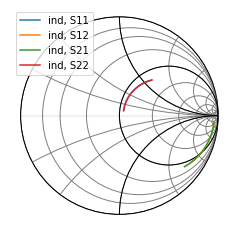

In [14]:
# Look at the raw inductor measurement with parasitics included
# From S11/S22, it is clear that it is not a pure inductance.

import skrf as rf
import numpy as np
import matplotlib.pyplot as plt

raw_ind = rf.Network('data/ind.s2p')
raw_ind.plot_s_smith()


If we were to extract inductance directly from this measurement, we will have an inductance value that changes with frequency, and the quality factor will also be influenced by the presence of parasitic resistors.

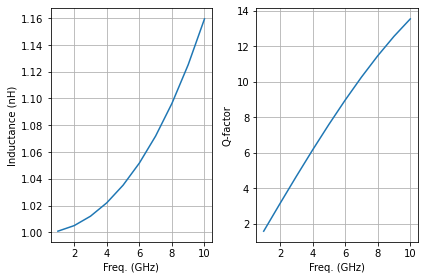

In [24]:
# plot the inductance and q-factor of the raw inductor measurement
Lraw_nH = 1e9 * np.imag(1/raw_ind.y[:,0,0])/2/np.pi/raw_ind.f
Qraw = np.abs(np.imag(1/raw_ind.y[:,0,0])/np.real(1/raw_ind.y[:,0,0]))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(raw_ind.f*1e-9, Lraw_nH)
ax1.grid(); ax1.set_ylabel("Inductance (nH)"); ax1.set_xlabel("Freq. (GHz)")
ax2.plot(raw_ind.f*1e-9, Qraw)
ax2.grid(); ax2.set_ylabel("Q-factor"); ax2.set_xlabel("Freq. (GHz)")
fig.tight_layout()

To create an open dummy structure, the DUT, which is the 1nH inductor here is simply removed from the DUT test structure resulting in the circuit shown below.

![openckt](figures/ind_open.png)

To create a short dummy structure, the interal terminals of the test-fixture that would otherwise connect to the DUT are shorted to ground as shown below.

![shortckt](figures/ind_short.png)

In [11]:
# load in short/open dummies as networks
open_nw = rf.Network('data/open.s2p')
short_nw = rf.Network('data/short.s2p')

To perform Open-Short de-embedding with the available dummy measurements, we create a de-embedding object as an instance of the `OpenShort` class, while providing the open and short network objects as arguments to the de-embedding object creation.

To get the de-embedded network, we apply the `deembed` method on the network object on which we want to perform the de-embedding operation. This is shown below.

OpenShort Deembedding: tutorial, 1000000000.0-10000000000.0 Hz, 10 pts, 2 dummy structures


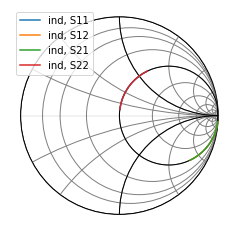

In [28]:
from skrf.calibration import OpenShort
dm = OpenShort(dummy_open=open_nw, dummy_short=short_nw, name='tutorial')

actual_ind = dm.deembed(raw_ind)
actual_ind.plot_s_smith()

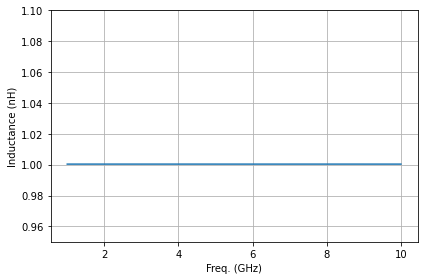

In [26]:
# plot the inductance of the de-embedded measurement
# we ignore plotting Q-factor here, because an ideal lossless inductor has infinite Q

Lactual_nH = 1e9 * np.imag(1/actual_ind.y[:,0,0])/2/np.pi/actual_ind.f

fig, ax1 = plt.subplots(1,1)
ax1.plot(actual_ind.f*1e-9, Lactual_nH)
ax1.grid(); ax1.set_ylim(0.95, 1.1)
ax1.set_ylabel("Inductance (nH)"); ax1.set_xlabel("Freq. (GHz)")
fig.tight_layout()

From the plot above, it is seen that the actual inductor value is accurately extracted even in the presence of unwanted parasitic elements due to proper de-embedding of the test-fixture.

## Other De-embedding Methods

Other simple forms of de-embedding included in scikit-rf are `Open`, `Short` and `ShortOpen` methods, which may be applicable depending on the equivalent circuit of the parasitic network of the test-fixture. As an example, it may be desirable to only remove the pad contact resistance from the measurement for which `Short` de-embedding can be used. In certain measurements, only the pad capacitance might need to be removed, for which the `Open` de-embedding method would be more appropriate. To remove pad contact resistance and pad capacitance in one operation, the `ShortOpen` method would be the most suitable.

Many other sophisticated methods of de-embedding have been reported in literature to extend the accuracy of DUT measurements up to high frequencies. While they can be done using the network operations of scikit-rf, their inclusion as a built-in de-embedding class within the package is welcomed as an open-source contribution to the project.